In [1]:
import numpy as np
import matplotlib.pyplot as plt



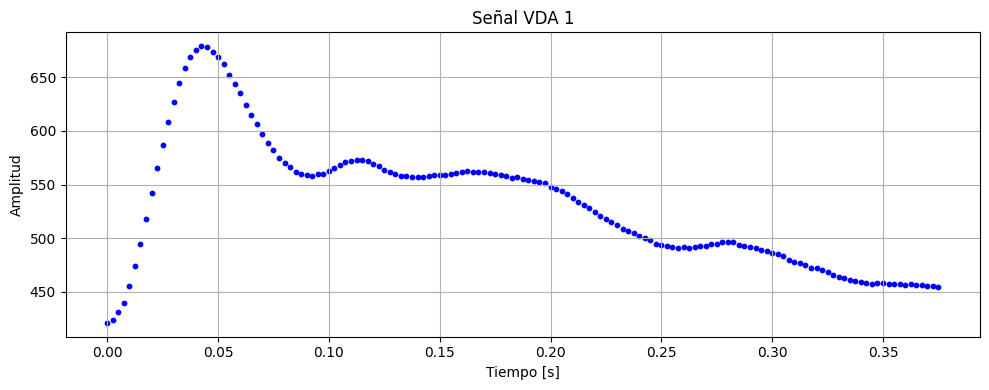

In [2]:
# Cargar solo el archivo 'samplesVDA1.txt'
archivo = 'samplesVDA1.txt'
vda_signal = np.loadtxt(archivo)

# Frecuencia de muestreo y eje temporal (en segundos)
fs = 400  # Hz
Ts = 1 / fs  # intervalo de muestreo: 2.5 ms
tiempo = np.arange(len(vda_signal)) * Ts  # eje x en segundos

# Graficar la señal
plt.figure(figsize=(10, 4))
plt.scatter(tiempo, vda_signal, color='blue', s=10)  # s es el tamaño de los puntos
plt.title('Señal VDA 1')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = subclust2(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    exp_val = -((data - mean)**2.) / (2 * sigma**2.)
    # fix de tipos:
    exp_val = exp_val.astype(np.float32)
    return np.exp( exp_val )

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self, muestra=True):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.muestra=muestra



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)

        if self.muestra:
            print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)
        
    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        if self.muestra:
            print("nivel_acti shape:", nivel_acti.shape)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        if self.muestra:
            print("sumMu shape:", sumMu.shape)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        # fix de tipos:
        A = A.astype(np.float32)
        b = b.astype(np.float32)

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        if self.muestra:
            print("solutions shape:", solutions.shape)
        #print(solutions)

        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()






--- 0.018462419509887695 seconds ---
nivel_acti shape: (151, 9)
sumMu shape: (151, 1)
solutions shape: (18,)
Cantidad de clusters encontrados: 9


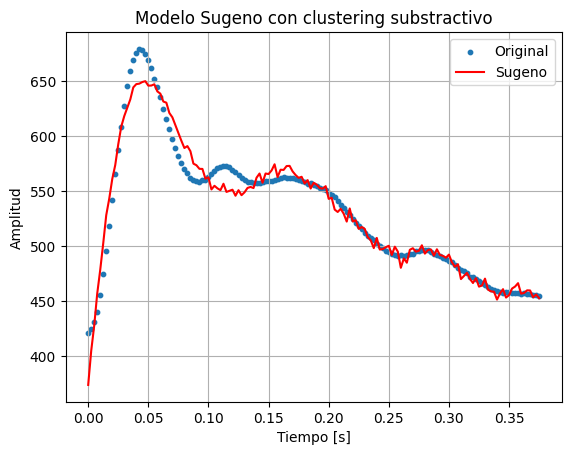

In [5]:
# Paso 1: Preparar los datos
data = np.vstack((tiempo, vda_signal)).T

# Paso 2: Entrenar el modelo Sugeno
modelo = fis()
modelo.genfis(data, radii=0.43)  # Cambiá el Ra hasta que obtengas 2 clusters
#radii      cluster
#2          1
#1.3337     1
#1.3336     3
# Mostramos la cantidad de clusters encontrados
print("Cantidad de clusters encontrados:", len(modelo.rules))


# Paso 3: Evaluar el modelo
salida_modelo = modelo.evalfis(data[:, 0].reshape(-1, 1))  # Solo la variable de entrada

# Paso 4: Graficar
plt.figure()
plt.scatter(tiempo, vda_signal, s=10, label="Original")
plt.plot(tiempo, salida_modelo, color='red', label="Sugeno")
plt.title("Modelo Sugeno con clustering substractivo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()


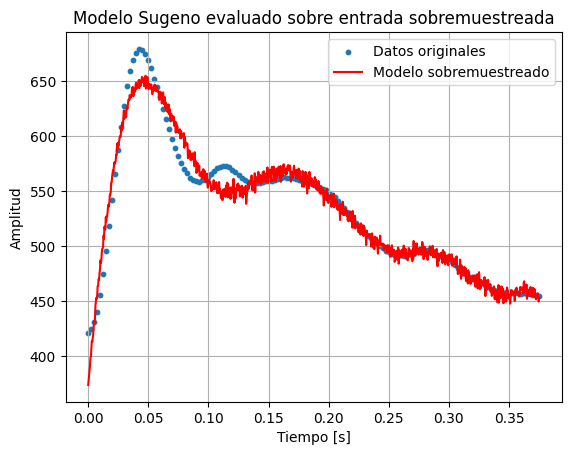

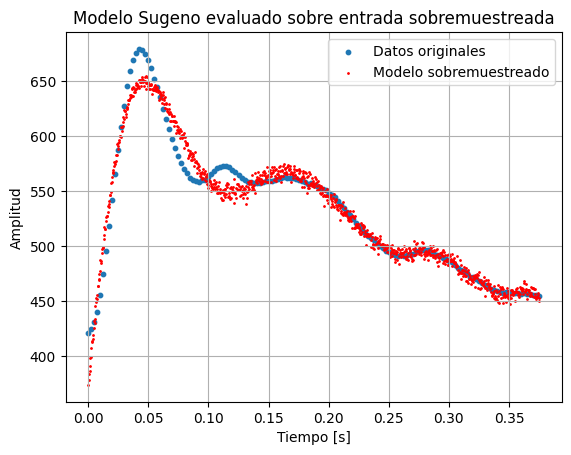

In [6]:
# Supongamos que tiempo es tu variable de entrada original
tiempo_min = np.min(tiempo)
tiempo_max = np.max(tiempo)

# Crear un vector de tiempo densificado (más puntos que los originales)
tiempo_denso = np.linspace(tiempo_min, tiempo_max, 1000)  # o más

# Evaluar el modelo sobre esta nueva malla
salida_densa = modelo.evalfis(tiempo_denso.reshape(-1, 1))

# Graficar
plt.figure()
plt.scatter(tiempo, vda_signal, s=10, label="Datos originales")
plt.plot(tiempo_denso, salida_densa, color='red', label="Modelo sobremuestreado")
plt.title("Modelo Sugeno evaluado sobre entrada sobremuestreada")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()

# Graficar
plt.figure()
plt.scatter(tiempo, vda_signal, s=10, label="Datos originales")
plt.scatter(tiempo_denso, salida_densa,s=1, color='red', label="Modelo sobremuestreado")
plt.title("Modelo Sugeno evaluado sobre entrada sobremuestreada")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()


MSE= 550.3682690833974   CantCluster= 151    radii= 0.01
MSE= 90.6653814878112   CantCluster= 127    radii= 0.02
MSE= 144.76766867592482   CantCluster= 105    radii= 0.03
MSE= 170.07771879627052   CantCluster= 82    radii= 0.04
MSE= 987.3717582643989   CantCluster= 69    radii= 0.05
MSE= 288.016767665681   CantCluster= 65    radii= 0.060000000000000005
MSE= 143.60861025512284   CantCluster= 54    radii= 0.06999999999999999
MSE= 397.5859308616681   CantCluster= 47    radii= 0.08
MSE= 133.0044147363667   CantCluster= 43    radii= 0.09
MSE= 147.7211690039417   CantCluster= 40    radii= 0.09999999999999999
MSE= 141.41351660489042   CantCluster= 37    radii= 0.11
MSE= 287.5416300890805   CantCluster= 33    radii= 0.12
MSE= 206.0616720917539   CantCluster= 35    radii= 0.13
MSE= 142.98501715340507   CantCluster= 33    radii= 0.14
MSE= 176.6912158276955   CantCluster= 30    radii= 0.15000000000000002
MSE= 155.60049479281517   CantCluster= 28    radii= 0.16
MSE= 164.41823469660255   CantCluste

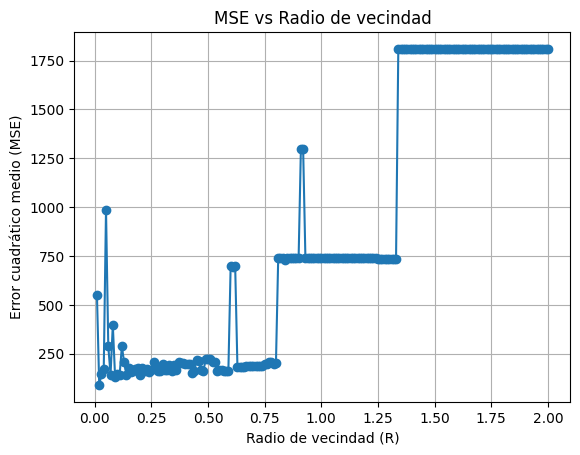

In [7]:
radii_values = np.linspace(0.01, 2.0, 200)  # por ejemplo, 20 valores entre 0.1 y 2.0
mse_values = []

for r in radii_values:
    modelo = fis(muestra=False)
    modelo.genfis(data, radii=r)
    y_pred = modelo.evalfis(data[:, 0].reshape(-1,1))
    y_true = data[:, 1]
    mse = np.mean((y_true - y_pred)**2)
    mse_values.append(mse)
    print("MSE=",mse,"  CantCluster=", len(modelo.rules),"   radii=",r)

plt.figure()
plt.plot(radii_values, mse_values, marker='o')
plt.xlabel('Radio de vecindad (R)')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('MSE vs Radio de vecindad')
plt.grid(True)
plt.show()